In [300]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import string
import re
import joblib
import pickle


from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sqlalchemy import create_engine
from confident import *
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer

In [155]:
df = pd.read_csv('datasets/billboard.zip')
df.head()

,date,year,title,simple_title,artist,main_artist,peak_pos,last_pos,weeks,rank,...,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics
0,6/21/18,NaN,4th Dimension,NaN,Kanye West and Kid Cudi,NaN,42,0,1,42,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Error: Could not find lyrics.
1,6/21/18,NaN,All Girls Are The Same,NaN,Juice WRLD,NaN,41,49,5,41,...,0.0769,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are..."
2,6/21/18,NaN,All Mine,NaN,Kanye West,NaN,11,11,2,31,...,0.125,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus..."
3,6/21/18,NaN,Alone,NaN,Halsey Featuring Big Sean & Stefflon Don,NaN,70,73,9,74,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Error: Could not find lyrics.
4,6/21/18,NaN,Babe,NaN,Sugarland Featuring Taylor Swift,NaN,72,0,2,95,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Error: Could not find lyrics.


In [156]:
df.shape

(7573, 31)

In [157]:
# Removing all rows that did not return lyrics
df = df[df['lyrics'].str.contains("Error: Could not find lyrics.") == False]

In [158]:
df.shape

(7228, 31)

In [159]:
df.head()

,date,year,title,simple_title,artist,main_artist,peak_pos,last_pos,weeks,rank,...,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics
1,6/21/18,NaN,All Girls Are The Same,NaN,Juice WRLD,NaN,41,49,5,41,...,0.0769,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are..."
2,6/21/18,NaN,All Mine,NaN,Kanye West,NaN,11,11,2,31,...,0.125,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus..."
5,6/21/18,NaN,Back To You,NaN,Selena Gomez,NaN,22,31,5,22,...,0.0945,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...
7,6/21/18,NaN,Be Careful,NaN,Cardi B,NaN,11,25,11,23,...,0.0256,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ..."
8,6/21/18,NaN,Beautiful Crazy,NaN,Luke Combs,NaN,58,77,4,93,...,0.676,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...


In [160]:
# Removing unnecessary columns from the dataframe
cols = ['simple_title', 'main_artist', 'year', 'peak_pos', 'last_pos', 'weeks', 'rank', 'change', 'video_link', 'broad_genre']
df = df.drop(cols, axis=1)

In [161]:
df.head()

,date,title,artist,spotify_link,spotify_id,genre,analysis_url,energy,liveness,tempo,...,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics
1,6/21/18,All Girls Are The Same,Juice WRLD,spotify:track:0XySogm94T51XF5F2jumXm,0XySogm94T51XF5F2jumXm,[u'rap'],https://api.spotify.com/v1/audio-analysis/0XyS...,0.529,0.0856,161.989,...,0.0769,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are..."
2,6/21/18,All Mine,Kanye West,spotify:track:3qnoOm4fwZPBS116f5hpgF,3qnoOm4fwZPBS116f5hpgF,"[u'pop rap', u'rap']",https://api.spotify.com/v1/audio-analysis/3qno...,0.308,0.0933,122.099,...,0.125,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus..."
5,6/21/18,Back To You,Selena Gomez,spotify:track:4hQ6UGyWQIGJmHSo0J88JW,4hQ6UGyWQIGJmHSo0J88JW,"[u'dance pop', u'pop', u'post-teen pop']",https://api.spotify.com/v1/audio-analysis/4hQ6...,0.724,0.12,102.061,...,0.0945,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...
7,6/21/18,Be Careful,Cardi B,spotify:track:2Yl4OmDby9iitgNWZPwxkd,2Yl4OmDby9iitgNWZPwxkd,"[u'pop', u'rap']",https://api.spotify.com/v1/audio-analysis/2Yl4...,0.568,0.0952,152.279,...,0.0256,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ..."
8,6/21/18,Beautiful Crazy,Luke Combs,spotify:track:4Qx06Fzsepmdz2NGSWfZck,4Qx06Fzsepmdz2NGSWfZck,"[u'contemporary country', u'country road']",https://api.spotify.com/v1/audio-analysis/4Qx0...,0.402,0.0928,103.313,...,0.676,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...


In [162]:
# This function removes the unnecessary "u" from each list of genres.
def genre_preprocess(text : str) -> str:
    text = re.sub("u'", "'", text)
    return text

In [163]:
# Run the function defined above on the "genre" column
df['genre'] = df.genre.apply(genre_preprocess)
df.head()

,date,title,artist,spotify_link,spotify_id,genre,analysis_url,energy,liveness,tempo,...,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics
1,6/21/18,All Girls Are The Same,Juice WRLD,spotify:track:0XySogm94T51XF5F2jumXm,0XySogm94T51XF5F2jumXm,['rap'],https://api.spotify.com/v1/audio-analysis/0XyS...,0.529,0.0856,161.989,...,0.0769,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are..."
2,6/21/18,All Mine,Kanye West,spotify:track:3qnoOm4fwZPBS116f5hpgF,3qnoOm4fwZPBS116f5hpgF,"['pop rap', 'rap']",https://api.spotify.com/v1/audio-analysis/3qno...,0.308,0.0933,122.099,...,0.125,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus..."
5,6/21/18,Back To You,Selena Gomez,spotify:track:4hQ6UGyWQIGJmHSo0J88JW,4hQ6UGyWQIGJmHSo0J88JW,"['dance pop', 'pop', 'post-teen pop']",https://api.spotify.com/v1/audio-analysis/4hQ6...,0.724,0.12,102.061,...,0.0945,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...
7,6/21/18,Be Careful,Cardi B,spotify:track:2Yl4OmDby9iitgNWZPwxkd,2Yl4OmDby9iitgNWZPwxkd,"['pop', 'rap']",https://api.spotify.com/v1/audio-analysis/2Yl4...,0.568,0.0952,152.279,...,0.0256,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ..."
8,6/21/18,Beautiful Crazy,Luke Combs,spotify:track:4Qx06Fzsepmdz2NGSWfZck,4Qx06Fzsepmdz2NGSWfZck,"['contemporary country', 'country road']",https://api.spotify.com/v1/audio-analysis/4Qx0...,0.402,0.0928,103.313,...,0.676,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...


In [164]:
df.shape

(7228, 21)

In [165]:
# This function cleans the text in the "lyrics" column
def clean_lyrics(text):
    text = text.lower()
    text = text.encode('ascii', 'ignore').decode()
    stop_words = stopwords.words('english')
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\w*\d+\w*', '', text)
    text = re.sub('\s{2,}', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub(' s ', ' ', text)
    text = re.sub(' m ', ' ', text)
    return text

In [166]:
# Apply the function defined above onto the "lyrics" colummn, also creating a new column called "clean_lyrics" as to not overwrite the original "lyrics" column
df['clean_lyrics'] = df.lyrics.apply(clean_lyrics)

In [167]:
# Removes unnecessary white space and ensures each word is delimited by a single space.
text = " ".join(i for i in df.clean_lyrics)

In [168]:
df.head()

,date,title,artist,spotify_link,spotify_id,genre,analysis_url,energy,liveness,tempo,...,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics,clean_lyrics
1,6/21/18,All Girls Are The Same,Juice WRLD,spotify:track:0XySogm94T51XF5F2jumXm,0XySogm94T51XF5F2jumXm,['rap'],https://api.spotify.com/v1/audio-analysis/0XyS...,0.529,0.0856,161.989,...,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are...",they re rotting brain love these hoes same i a...
2,6/21/18,All Mine,Kanye West,spotify:track:3qnoOm4fwZPBS116f5hpgF,3qnoOm4fwZPBS116f5hpgF,"['pop rap', 'rap']",https://api.spotify.com/v1/audio-analysis/3qno...,0.308,0.0933,122.099,...,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus...",yeah supermodel thick damn ass bustin bottom i...
5,6/21/18,Back To You,Selena Gomez,spotify:track:4hQ6UGyWQIGJmHSo0J88JW,4hQ6UGyWQIGJmHSo0J88JW,"['dance pop', 'pop', 'post-teen pop']",https://api.spotify.com/v1/audio-analysis/4hQ6...,0.724,0.12,102.061,...,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...,took like shot thought could chase cold evenin...
7,6/21/18,Be Careful,Cardi B,spotify:track:2Yl4OmDby9iitgNWZPwxkd,2Yl4OmDby9iitgNWZPwxkd,"['pop', 'rap']",https://api.spotify.com/v1/audio-analysis/2Yl4...,0.568,0.0952,152.279,...,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ...",yeah be careful careful careful me yeah look i...
8,6/21/18,Beautiful Crazy,Luke Combs,spotify:track:4Qx06Fzsepmdz2NGSWfZck,4Qx06Fzsepmdz2NGSWfZck,"['contemporary country', 'country road']",https://api.spotify.com/v1/audio-analysis/4Qx0...,0.402,0.0928,103.313,...,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...,day starts coffee and ends wine takes forever ...


In [169]:
df.shape

(7228, 22)

In [170]:
# Dropping all duplicates from the dataset. Some of the spotify IDs were duplicated
df = df.drop_duplicates(subset='spotify_id')

In [171]:
# Dropping all rows with a NULL value for the spotify_id column
df = df.dropna(subset=['spotify_id'])

In [172]:
# Reseting the index count to avoid multiple rows having the same index and to avoid fractured index counts.
df = df.reset_index(drop=True)
df.head()

,date,title,artist,spotify_link,spotify_id,genre,analysis_url,energy,liveness,tempo,...,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics,clean_lyrics
0,6/21/18,All Girls Are The Same,Juice WRLD,spotify:track:0XySogm94T51XF5F2jumXm,0XySogm94T51XF5F2jumXm,['rap'],https://api.spotify.com/v1/audio-analysis/0XyS...,0.529,0.0856,161.989,...,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are...",they re rotting brain love these hoes same i a...
1,6/21/18,All Mine,Kanye West,spotify:track:3qnoOm4fwZPBS116f5hpgF,3qnoOm4fwZPBS116f5hpgF,"['pop rap', 'rap']",https://api.spotify.com/v1/audio-analysis/3qno...,0.308,0.0933,122.099,...,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus...",yeah supermodel thick damn ass bustin bottom i...
2,6/21/18,Back To You,Selena Gomez,spotify:track:4hQ6UGyWQIGJmHSo0J88JW,4hQ6UGyWQIGJmHSo0J88JW,"['dance pop', 'pop', 'post-teen pop']",https://api.spotify.com/v1/audio-analysis/4hQ6...,0.724,0.12,102.061,...,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...,took like shot thought could chase cold evenin...
3,6/21/18,Be Careful,Cardi B,spotify:track:2Yl4OmDby9iitgNWZPwxkd,2Yl4OmDby9iitgNWZPwxkd,"['pop', 'rap']",https://api.spotify.com/v1/audio-analysis/2Yl4...,0.568,0.0952,152.279,...,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ...",yeah be careful careful careful me yeah look i...
4,6/21/18,Beautiful Crazy,Luke Combs,spotify:track:4Qx06Fzsepmdz2NGSWfZck,4Qx06Fzsepmdz2NGSWfZck,"['contemporary country', 'country road']",https://api.spotify.com/v1/audio-analysis/4Qx0...,0.402,0.0928,103.313,...,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...,day starts coffee and ends wine takes forever ...


In [173]:
df.shape

(6776, 22)

Text Visualization

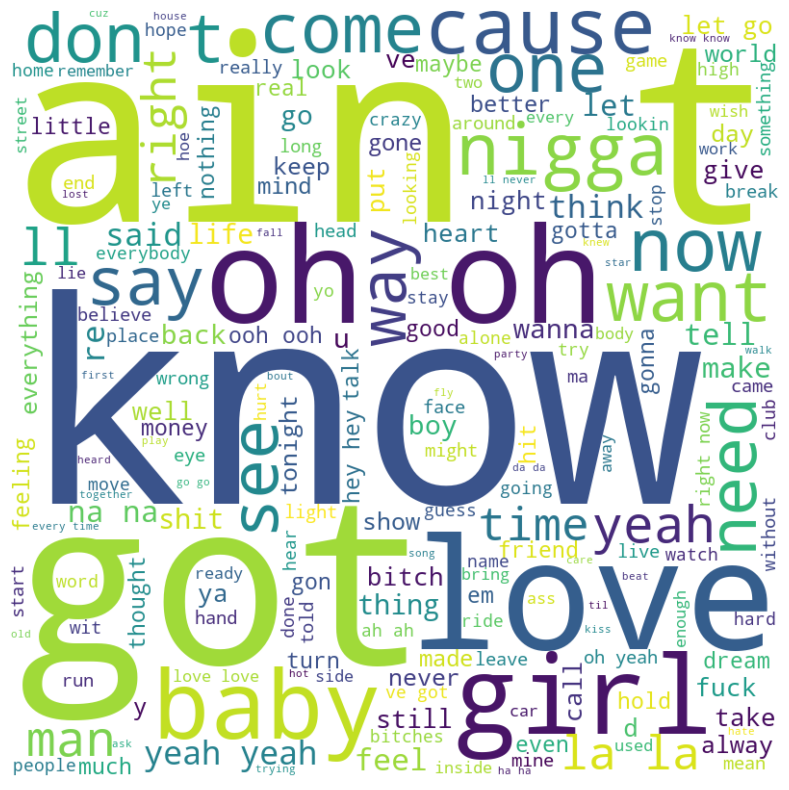

In [174]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(text)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [175]:
def get_playlist_details(df, spotify_ids):
    """This function takes in the user's playlist and returns the spotify IDs and the playlist lyrics.
    
        Args -
            df : A 2D pandas dataframe that contains the cleaned dataset.
            spotify_id : A list of strings that contains the spotify IDs of the users playlist
             
        Returns -
            user_playlist_song_ids : A list of strings that contains the song IDs of the user's playlist.
            user_playlist_lyrics : A single string that contains all of the lyrics of the user's playlist.
            """
    

    row_num = df[df['spotify_id'].isin(spotify_ids)]
    print("Playlist User Enterd:")
    print(row_num[['title', 'artist', 'spotify_id']])

    # Get the Spotify IDs for the songs in the user's playlist
    user_playlist_song_ids = row_num['spotify_id']

    # Combine the lyrics from each of the songs in the user's playlist into one string
    user_playlist_lyrics = ' '.join(row_num['clean_lyrics'].tolist())

    # Return the Spotify song IDs and the string containing the lyrics of the entire playlist
    return user_playlist_song_ids, user_playlist_lyrics

Here I am generating a random playlist in order to test the function. 
    - I generate a random playlist.
    - Pass in the dataframe containing all songs and the spotify IDs from the playlist I just generated.
    - Return the song IDs and the lyrics from the playlist

In [273]:
sp_ids = df['spotify_id']
user_playlist_song_ids, user_playlist_lyrics = get_playlist_details(df=df, spotify_ids=sp_ids.sample(n=7))

Playlist User Enterd:
                      title             artist              spotify_id
318            Relationship         young thug  25oOaleife6E2MIKmFkPvg
419                 Privacy        chris brown  2Vf2Pflg5rTWSvSCK4qq4A
2100         People Like Us     kelly clarkson  6yycpXzFKgEeCMXbDwj9bg
3039         I Just Had Sex  the lonely island  6eG57n71RMwtmtmeJxinSQ
3562  History In The Making      darius rucker  1J4HTEFSDx9DWyJVH5uv1b
4310         Duffle Bag Boy      playaz circle  2eQrNKKp1Ha06b52m8zy5G
4830    DJ Play A Love Song         jamie foxx  2F1H1Tm2qJmeiFcUi7vZiL


Here I am creating a Tf-idf vectorizer object, and fitting the clean lyrics column onto it.

In [296]:
def tf_idf_generate_recommendations(user_playlist_song_ids, user_playlist_lyrics):

    # Create a new column with the combined clean lyrics for each song
    clean_lyrics = df['clean_lyrics']

    # Create a Tf-idf vectorizer object
    vectorizer = TfidfVectorizer()

    # Fit the vectorizer to the lyrics, creating a tf-idf matrix where the words are the features
    tfidf_matrix = vectorizer.fit_transform(clean_lyrics)

    # Transform the user playlist into a Tf-idf vector
    user_tfidf = vectorizer.transform([user_playlist_lyrics])

    # Calculate the cosine similarities between the user playlist vector and all the songs
    cosine_similarities = cosine_similarity(user_tfidf, tfidf_matrix).flatten()

    # Sort the songs by similarity score in descending order
    song_indices = cosine_similarities.argsort()[::-1]

    # Get the top N number of song recommendations without duplicating the songs in the user's playlist
    recommended_songs = []
    for i in song_indices:
        if len(recommended_songs) == 10:
            break
        elif df.loc[i, 'spotify_id'] in user_playlist_song_ids:
            continue
        else:
            recommended_songs.append(df.loc[i, 'spotify_id'])

    # Return the recommended songs, what is returned are the spotify IDs of the songs
    return recommended_songs

In [297]:
# Test the function
tf_idf_recommendations = tf_idf_generate_recommendations(user_playlist_song_ids=user_playlist_song_ids, user_playlist_lyrics=user_playlist_lyrics)

# Obtaining the details (i.e the song title and artist) from the spotify IDs returned by the generate_recommendations function.
song_details = df[df['spotify_id'].isin(tf_idf_recommendations)].drop_duplicates(subset='spotify_id')

Evaluating the TF-IDF function

In [298]:
NUM_USERS = 100

# Create a list of user IDs and item IDs
user_ids = ['user{}'.format(i) for i in range (1, NUM_USERS + 1)]

# Grab all spotify IDs from the dataset
spotify_ids = df['spotify_id'].unique()

# Create a user-item matrix with random values for each user 
data = np.random.randint(0, 101, size=(100, 6776))
user_item_matrix = pd.DataFrame(data=data, index=user_ids, columns=spotify_ids)

In [299]:
# Generate a random playlist for each user with 10 songs
user_playlists = {}
for user in user_ids:
    user_value = [ord(char) for char in user]
    user_value = int(sum(user_value) / len(user_value)) + random.randint(1, 100)
    np.random.seed(user_value) # use the user ID as the seed
    user_playlists[user] = np.random.choice(spotify_ids, size=10, replace=False)

tf_idf_user_recommendations = {}
for user, playlist in user_playlists.items():
    user_playlist_song_ids, user_playlist_lyrics = get_playlist_details(df=df, spotify_ids=playlist)
    tf_idf_user_recommendations[user] = tf_idf_generate_recommendations(user_playlist_song_ids=user_playlist_song_ids, user_playlist_lyrics=user_playlist_lyrics)

    # Obtaining the details (i.e the song title and artist) from the spotify IDs returned by the generate_recommendations function.
    song_details = df[df['spotify_id'].isin(tf_idf_user_recommendations[user])].drop_duplicates(subset='spotify_id')

Playlist User Enterd:
                       title             artist              spotify_id
29                     Japan         Famous Dex  5PTG6rrL6EPFD9E2QMI2pl
717           What They Want               russ  3pndPhlQWjuSoXhcIIdBjv
1374                Everyday         a$ap rocky  2N3U8uTYhjX2KwGT0pf5x0
2547      I Dont Really Care  waka flocka flame  5bK4oJXvHUqwI0ZpLtrnOl
3097             Mama's Song   carrie underwood  0HicNcPLKNp2YTnGRjj2te
3109            Hold My Hand    michael jackson  0pCyoA5o2uxUwIovECCziF
4001         Shattered Glass     britney spears  0JIOI98h3eaifxXnEkBO2C
4611  Not Ready To Make Nice       dixie chicks  5dPfweC4kFNvS45Hke0FBF
5545   In My Daughter's Eyes    martina mcbride  7LkQBDAiS0GVSO5JQuYDzY
6748   Don't Say You Love Me                m2m  65i1UPsUtPlEVzewEZR6sY
Playlist User Enterd:
                         title                        artist  \
155                 MotorSport  Migos, Nicki Minaj & Cardi B   
1570           Burnin' It Down      

In [280]:
# Generate Precision, Recall, and f1 scores for the recommendations based on if the song recommended is in the user's playlist for TF-IDF
tf_idf_precision_scores = []
tf_idf_recall_scores = []
tf_idf_f1_scores = []
for user, tf_idf_recommendations in tf_idf_user_recommendations.items():
    # Get the songs in the user's playlist
    user_playlist = user_playlists[user]
    # Get the number of songs in the user's playlist that were recommended
    num_recommended_in_playlist = len(set(tf_idf_recommendations).intersection(user_playlist))
    # Calculate the precision score for the user's recommendations
    precision = num_recommended_in_playlist / len(tf_idf_recommendations)
    # Calculate the recall score for the user's recommendations
    recall = num_recommended_in_playlist / len(user_playlist)
    # Calculate the f1 score for the user's recommendations
    f1 = 2 * (precision * recall) / (precision + recall)
    # Append the scores to the lists
    tf_idf_precision_scores.append(precision)
    tf_idf_recall_scores.append(recall)
    tf_idf_f1_scores.append(f1)

print("Precision Scores: ", tf_idf_precision_scores)
print("Recall Scores: ", tf_idf_recall_scores)
print("F1 Scores: ", tf_idf_f1_scores)


Precision Scores:  [0.8, 0.2, 0.8, 0.6, 0.6, 0.5, 0.1, 0.8, 0.5, 0.7, 0.6, 0.6, 0.2, 0.6, 0.1, 0.8, 0.7, 0.7, 0.8, 0.5, 0.4, 0.9, 0.4, 0.6, 0.7, 0.3, 0.6, 0.7, 0.5, 0.8, 0.9, 0.4, 0.6, 0.3, 0.8, 0.4, 0.6, 0.2, 0.6, 0.7, 0.5, 0.6, 0.6, 0.8, 0.4, 0.3, 0.4, 0.4, 0.5, 0.8, 0.6, 0.7, 0.6, 0.8, 0.1, 0.2, 0.6, 0.6, 0.4, 0.6, 0.5, 0.6, 0.8, 0.7, 0.6, 0.6, 0.7, 0.7, 0.3, 0.6, 0.7, 0.4, 0.1, 0.1, 0.8, 0.8, 0.6, 0.1, 0.6, 0.7, 0.6, 0.6, 0.3, 0.7, 0.6, 0.9, 0.7, 0.4, 0.9, 0.5, 0.7, 0.5, 0.6, 0.3, 0.8, 0.5, 0.7, 0.6, 0.9, 0.7]
Recall Scores:  [0.8, 0.2, 0.8, 0.6, 0.6, 0.5, 0.1, 0.8, 0.5, 0.7, 0.6, 0.6, 0.2, 0.6, 0.1, 0.8, 0.7, 0.7, 0.8, 0.5, 0.4, 0.9, 0.4, 0.6, 0.7, 0.3, 0.6, 0.7, 0.5, 0.8, 0.9, 0.4, 0.6, 0.3, 0.8, 0.4, 0.6, 0.2, 0.6, 0.7, 0.5, 0.6, 0.6, 0.8, 0.4, 0.3, 0.4, 0.4, 0.5, 0.8, 0.6, 0.7, 0.6, 0.8, 0.1, 0.2, 0.6, 0.6, 0.4, 0.6, 0.5, 0.6, 0.8, 0.7, 0.6, 0.6, 0.7, 0.7, 0.3, 0.6, 0.7, 0.4, 0.1, 0.1, 0.8, 0.8, 0.6, 0.1, 0.6, 0.7, 0.6, 0.6, 0.3, 0.7, 0.6, 0.9, 0.7, 0.4, 0.9, 0.5, 0.7, 0.5, 0.6

In [281]:
# Print the average precision, recall, and f1 scores for the TF-IDF recommendations
print("Average Precision Score: ", np.mean(tf_idf_precision_scores))
print("Average Recall Score: ", np.mean(tf_idf_recall_scores))
print("Average F1 Score: ", np.mean(tf_idf_f1_scores))

Average Precision Score:  0.5660000000000001
Average Recall Score:  0.5660000000000001
Average F1 Score:  0.5660000000000001


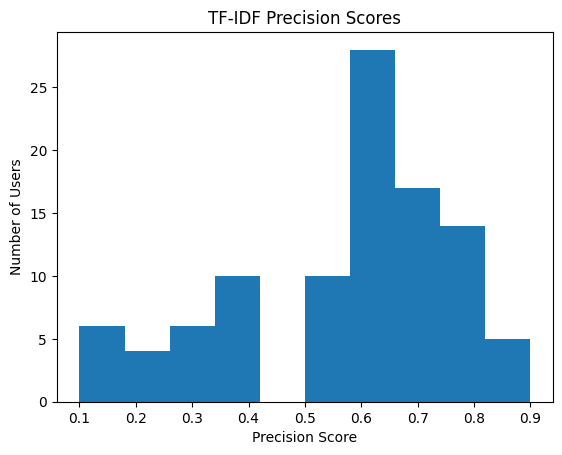

In [282]:
# Show the distribution of the precision scores in a chart
plt.hist(tf_idf_precision_scores)
plt.title('TF-IDF Precision Scores')
plt.xlabel('Precision Score')
plt.ylabel('Number of Users')
plt.show()

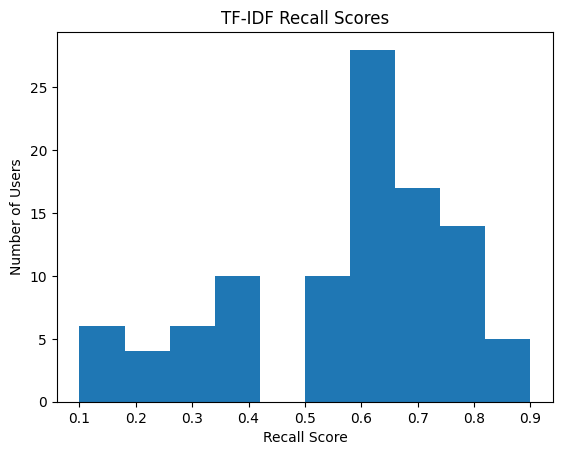

In [283]:
# Show the distribution of the recall scores in a chart
plt.hist(tf_idf_recall_scores)
plt.title('TF-IDF Recall Scores')
plt.xlabel('Recall Score')
plt.ylabel('Number of Users')
plt.show()

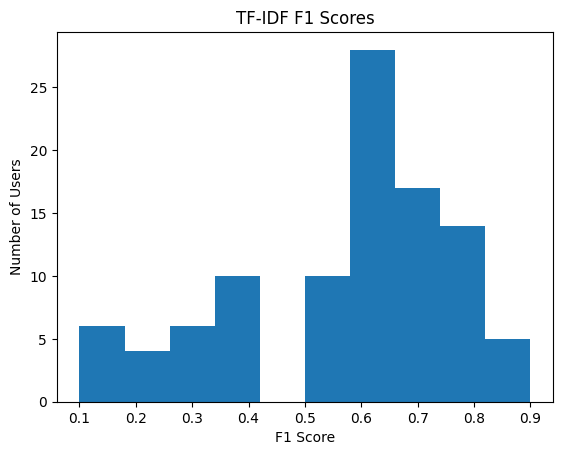

In [284]:
# Show the distribution of the f1 scores in a chart
plt.hist(tf_idf_f1_scores)
plt.title('TF-IDF F1 Scores')
plt.xlabel('F1 Score')
plt.ylabel('Number of Users')
plt.show()

Count Vectorizer

In [301]:
# Define a function to generate recommendations using the CountVectorizer
def count_vectorizer_generate_recommendations(user_playlist_song_ids, user_playlist_lyrics):
    # Create a new column with the combined clean lyrics for each song
    clean_lyrics = df['clean_lyrics']

    # Create a CountVectorizer object
    vectorizer = CountVectorizer()

    # Fit the vectorizer to the lyrics, creating a count matrix where the words are the features
    count_matrix = vectorizer.fit_transform(clean_lyrics)

    # Transform the user playlist into a count vector
    user_count = vectorizer.transform([user_playlist_lyrics])

    # Calculate the cosine similarities between the user playlist vector and all the songs
    cosine_similarities = cosine_similarity(user_count, count_matrix).flatten()

    # Sort the songs by similarity score in descending order
    song_indices = cosine_similarities.argsort()[::-1]

    # Get the top N number of song recommendations without duplicating the songs in the user's playlist
    recommended_songs = []
    for i in song_indices:
        if len(recommended_songs) == 10:
            break
        elif df.loc[i, 'spotify_id'] in user_playlist_song_ids:
            continue
        else:
            recommended_songs.append(df.loc[i, 'spotify_id'])

    # Return the recommended songs, what is returned are the spotify IDs of the songs
    return recommended_songs

In [305]:
# Generate recommendations for each user using the CountVectorizer
count_vectorizer_user_recommendations = {}
for user, playlist in user_playlists.items():
    user_playlist_song_ids, user_playlist_lyrics = get_playlist_details(df=df, spotify_ids=playlist)
    count_vectorizer_user_recommendations[user] = count_vectorizer_generate_recommendations(user_playlist_song_ids=user_playlist_song_ids, user_playlist_lyrics=user_playlist_lyrics)

    # Obtaining the details (i.e the song title and artist) from the spotify IDs returned by the generate_recommendations function.
    song_details = df[df['spotify_id'].isin(count_vectorizer_user_recommendations[user])].drop_duplicates(subset='spotify_id')

# Generate Precision, Recall, and f1 scores for the recommendations based on if the song recommended is in the user's playlist for CountVectorizer
count_vectorizer_precision_scores = []
count_vectorizer_recall_scores = []
count_vectorizer_f1_scores = []
for user, count_vectorizer_recommendations in count_vectorizer_user_recommendations.items():
    # Get the songs in the user's playlist
    user_playlist = user_playlists[user]
    # Get the number of songs in the user's playlist that were recommended
    num_recommended_in_playlist = len(set(count_vectorizer_recommendations).intersection(user_playlist))
    # Calculate the precision score for the user's recommendations
    precision = num_recommended_in_playlist / len(count_vectorizer_recommendations)
    # Calculate the recall score for the user's recommendations
    recall = num_recommended_in_playlist / len(user_playlist)
    # Calculate the f1 score for the user's recommendations without zero division error
    if precision == 0 and recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
    # Append the scores to the lists
    count_vectorizer_precision_scores.append(precision)
    count_vectorizer_recall_scores.append(recall)
    count_vectorizer_f1_scores.append(f1)

print("Precision Scores: ", count_vectorizer_precision_scores)
print("Recall Scores: ", count_vectorizer_recall_scores)
print("F1 Scores: ", count_vectorizer_f1_scores)

Playlist User Enterd:
                       title             artist              spotify_id
29                     Japan         Famous Dex  5PTG6rrL6EPFD9E2QMI2pl
717           What They Want               russ  3pndPhlQWjuSoXhcIIdBjv
1374                Everyday         a$ap rocky  2N3U8uTYhjX2KwGT0pf5x0
2547      I Dont Really Care  waka flocka flame  5bK4oJXvHUqwI0ZpLtrnOl
3097             Mama's Song   carrie underwood  0HicNcPLKNp2YTnGRjj2te
3109            Hold My Hand    michael jackson  0pCyoA5o2uxUwIovECCziF
4001         Shattered Glass     britney spears  0JIOI98h3eaifxXnEkBO2C
4611  Not Ready To Make Nice       dixie chicks  5dPfweC4kFNvS45Hke0FBF
5545   In My Daughter's Eyes    martina mcbride  7LkQBDAiS0GVSO5JQuYDzY
6748   Don't Say You Love Me                m2m  65i1UPsUtPlEVzewEZR6sY
Playlist User Enterd:
                         title                        artist  \
155                 MotorSport  Migos, Nicki Minaj & Cardi B   
1570           Burnin' It Down      

In [306]:
# Print the average precision, recall, and f1 scores for the CountVectorizer recommendations
print("Average Precision Score: ", np.mean(count_vectorizer_precision_scores))
print("Average Recall Score: ", np.mean(count_vectorizer_recall_scores))
print("Average F1 Score: ", np.mean(count_vectorizer_f1_scores))

Average Precision Score:  0.21000000000000005
Average Recall Score:  0.21000000000000005
Average F1 Score:  0.21000000000000005


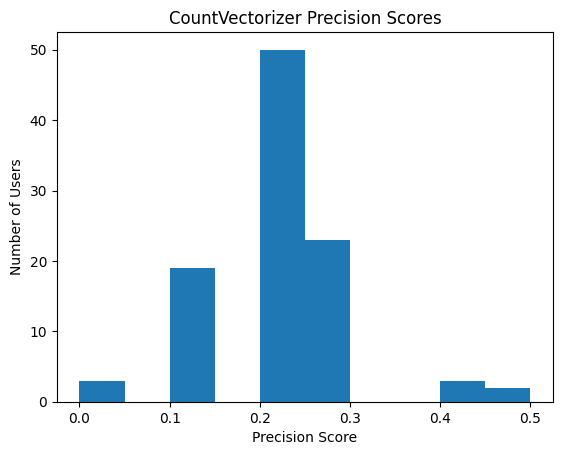

In [307]:
# Show the distribution of the precision scores in a chart
plt.hist(count_vectorizer_precision_scores)
plt.title('CountVectorizer Precision Scores')
plt.xlabel('Precision Score')
plt.ylabel('Number of Users')
plt.show()

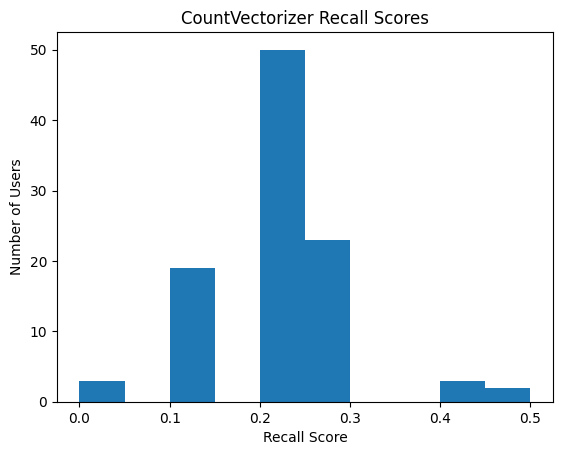

In [308]:
# Show the distribution of the recall scores in a chart
plt.hist(count_vectorizer_recall_scores)
plt.title('CountVectorizer Recall Scores')
plt.xlabel('Recall Score')
plt.ylabel('Number of Users')
plt.show()

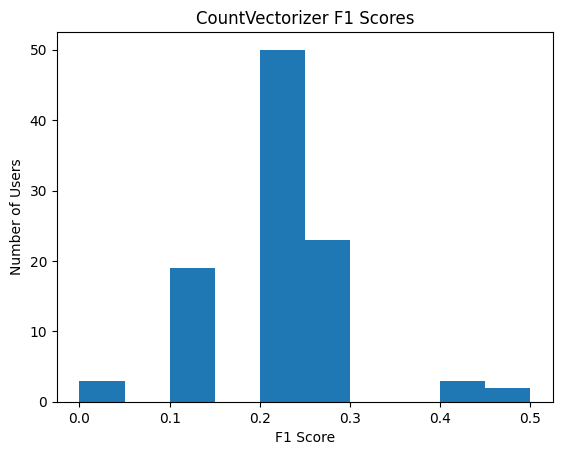

In [309]:
# Show the distribution of the f1 scores in a chart
plt.hist(count_vectorizer_f1_scores)
plt.title('CountVectorizer F1 Scores')
plt.xlabel('F1 Score')
plt.ylabel('Number of Users')
plt.show()

In [196]:
lstm_model = joblib.load('nlp_rnn.pkl')


2023-04-26 20:22:00.309476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-26 20:22:00.314605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-26 20:22:00.318455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [197]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________


In [198]:
print(lstm_model)

In [199]:
type(lstm_model)

keras.engine.sequential.Sequential

In [200]:
# Get the "clean_lyrics" column from the DataFrame
lyrics = df['clean_lyrics'].values

def encoding(lyrics):
    # Create a Tokenizer object
    tokenizer = Tokenizer(num_words=5000)

    # Fit the tokenizer on the text data
    tokenizer.fit_on_texts(lyrics)

    # Perform tokenization on the text data
    sequences = tokenizer.texts_to_sequences(lyrics)

    # Define the maximum sequence length for padding
    max_len = 500  # Set to an appropriate value based on your data

    # Pad the sequences to have the same length
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

    return padded_sequences, tokenizer

# Get the vocabulary size
vs = encoding(lyrics)[1]
vocab_size = len(vs.word_index) + 1

# The padded_sequences variable now contains the index-based encoded text data
# which can be used as input to an RNN model for training or prediction
# You can use the padded_sequences variable in your RNN model along with other features as needed



In [ ]:
padded_sequences = encoding(lyrics)[0]

In [202]:
# Use RNN model to predict sentiment for each song in the user playlist
def predict_sentiment(lyrics, model):
    # Encode the lyrics using the Tokenizer object
    padded_sequences = encoding(lyrics)[0]

    # Make predictions using the RNN model
    predictions = model.predict(padded_sequences)

    print(predictions)

    # Convert the predictions into sentiment labels
    sentiment_labels = ['positive' if prediction > 0.96833 else 'negative' for prediction in predictions]

    return sentiment_labels

# Get the sentiment labels for each song in the user playlist
sentiment_labels = predict_sentiment(user_playlist_lyrics, lstm_model)



2023-04-26 20:22:05.817175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-26 20:22:05.819650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-26 20:22:05.821603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

513/513 [==============================] - 31s 59ms/step
[[0.9868329]
 [0.9868329]
 [0.9868329]
 ...
 [0.9868329]
 [0.9868329]
 [0.9868329]]


In [204]:
df['sentiment'] = ''

# Loop through each row in the df dataframe
for i in range(df.shape[0]):
    # Get the index of the row
    index = df.index[i]

    # Get the lyrics for the song
    lyrics = df.loc[index, 'clean_lyrics']

    # Predict the sentiment of the lyrics
    sentiment = predict_sentiment([lyrics], lstm_model)[0]

    # Update the sentiment column with the predicted sentiment
    df.loc[index, 'sentiment'] = sentiment

print(df.head(5))

1/1 [==============================] - 0s 35ms/step
[[0.9868329]]
1/1 [==============================] - 0s 35ms/step
[[0.9868329]]
1/1 [==============================] - 0s 35ms/step
[[0.98683286]]
1/1 [==============================] - 0s 53ms/step
[[0.98683286]]
1/1 [==============================] - 0s 59ms/step
[[0.9868329]]
1/1 [==============================] - 0s 73ms/step
[[0.98683286]]
1/1 [==============================] - 0s 58ms/step
[[0.98683274]]
1/1 [==============================] - 0s 48ms/step
[[0.9868329]]
1/1 [==============================] - 0s 37ms/step
[[0.98683286]]
1/1 [==============================] - 0s 33ms/step
[[0.98689413]]
1/1 [==============================] - 0s 36ms/step
[[0.9868329]]
1/1 [==============================] - 0s 32ms/step
[[0.01494831]]
1/1 [==============================] - 0s 34ms/step
[[0.93089396]]
1/1 [==============================] - 0s 54ms/step
[[0.9868329]]
1/1 [==============================] - 0s 54ms/step
[[0.9868329]]
1/

In [219]:
# Grab the user's playlist lyrics from the user_playlists dictionary
user_playlist_lyrics = user_playlists[user]

# Grab the lyrics from the corresponding spotify IDs in the user_playlist_lyrics list
user_playlist_lyrics = df[df['spotify_id'].isin(user_playlist_lyrics)]['clean_lyrics'].values

# Encode the lyrics using the Tokenizer object
padded_sequences = encoding(user_playlist_lyrics)[0]

# Make predictions using the RNN model
predictions = lstm_model.predict(padded_sequences)


# Label each song in dataframe with correct sentiment label
for i in range(len(predictions)):
    if predictions[i] > 0.96833:
        df['sentiment'].iloc[i] = 'positive'
    else:
        df['sentiment'].iloc[i] = 'negative'

# Convert the predictions into sentiment labels
sentiment_labels = ['positive' if prediction > 0.96833 else 'negative' for prediction in predictions]

# Return songs that correspond with the ratio of positive and negative sentiment labels to the user
def recommend_songs(sentiment_labels, user_playlist_lyrics, df, n=10):
    print(type(df))
    # Get the number of positive and negative sentiment labels
    num_positive = sentiment_labels.count('positive')
    num_negative = sentiment_labels.count('negative')

    # Calculate the ratio of positive and negative sentiment labels
    positive_ratio = num_positive / (num_positive + num_negative)
    negative_ratio = num_negative / (num_positive + num_negative)

    # Return songs that correspond with the ratio of positive and negative sentiment labels to the user
    if positive_ratio > negative_ratio:
        # Return the top-n songs with the highest positive sentiment
        return df[df['clean_lyrics'].isin(user_playlist_lyrics)][df['sentiment'] == 'positive']['spotify_id'].values[:n]
    else:
        # Return the top-n songs with the highest negative sentiment
        return df[df['clean_lyrics'].isin(user_playlist_lyrics)][df['sentiment'] == 'negative']['spotify_id'].values[:n]
    
# Get the recommended songs for the user
rnn_recommended_songs = recommend_songs(sentiment_labels=sentiment_labels, user_playlist_lyrics=user_playlist_lyrics, df=df)

# Convert this list to a dictionary
rnn_recommended_songs = {user: rnn_recommended_songs}

print(rnn_recommended_songs)

1/1 [==============================] - 0s 55ms/step
<class 'pandas.core.frame.DataFrame'>
{'user100': array(['3a1lNhkSLSkpJE4MSHpDu9', '07GilNHSfS5oicUgHgU7VG',
       '4rra3z09djKcOviLkHWN6l', '4erIrODaoV04TQrgFFaTbm',
       '0L4YCNRfXAoTvdpWeH2RGj', '7DfFc7a6Rwfi3YQMRbDMau',
       '7CxhdANGZEPZ3BoTjFMKP3', '7HhR1L61r3Z3PMWRRJSDHe',
       '72mr7QyZEQbrX89SxtePOc'], dtype=object)}


/var/folders/b8/tkxd7yxj1672bq9d4m_3xmhh0000gn/T/ipykernel_13747/3396847318.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df[df['clean_lyrics'].isin(user_playlist_lyrics)][df['sentiment'] == 'positive']['spotify_id'].values[:n]


In [310]:
# Recommend songs to the user using the LSTM model
def recommend_songs_lstm(user, user_playlists, df, model, n=10):
    # Grab the user's playlist lyrics from the user_playlists dictionary
    user_playlist_lyrics = user_playlists[user]

    # Grab the lyrics from the corresponding spotify IDs in the user_playlist_lyrics list
    user_playlist_lyrics = df[df['spotify_id'].isin(user_playlist_lyrics)]['clean_lyrics'].values

    # Encode the lyrics using the Tokenizer object
    padded_sequences = encoding(user_playlist_lyrics)[0]

    # Make predictions using the RNN model
    predictions = model.predict(padded_sequences)

    # Convert the predictions into sentiment labels
    sentiment_labels = ['positive' if prediction > 0.96833 else 'negative' for prediction in predictions]

    # Get the number of positive and negative sentiment labels
    num_positive = sentiment_labels.count('positive')
    num_negative = sentiment_labels.count('negative')

    # Calculate the ratio of positive and negative sentiment labels
    positive_ratio = num_positive / (num_positive + num_negative)
    negative_ratio = num_negative / (num_positive + num_negative)

    # Return songs that correspond with the ratio of positive and negative sentiment labels to the user
    if positive_ratio > negative_ratio:
        # Return the top-n songs with the highest positive sentiment
        return df[df['clean_lyrics'].isin(user_playlist_lyrics)][df['sentiment'] == 'positive']['spotify_id'].values[:n]
    else:
        # Return the top-n songs with the highest negative sentiment
        return df[df['clean_lyrics'].isin(user_playlist_lyrics)][df['sentiment'] == 'negative']['spotify_id'].values[:n]
    
# Get the recommended songs for the user
rnn_recommended_songs = recommend_songs_lstm(user=user, user_playlists=user_playlists, df=df, model=lstm_model)

# Convert this list to a dictionary
rnn_recommended_songs = {user: rnn_recommended_songs}

print(rnn_recommended_songs)

1/1 [==============================] - 0s 104ms/step
{'user100': array(['06gD2ZtK3Dzc1BYqWExQJJ', '13e6f8t7RKXuxZ0JdaaJRG',
       '2272QqVQiM9VYGac3O2dVd', '5Wd2bfQ7wc6GgSa32OmQU3',
       '0elaYQVBPOQSp7G3P9AQ7C', '6TrLJzbFF1ynWWBipAlf0g',
       '7zywdG4ysfC5XNBzjQAo2o', '1DSJNBNhGZCigg9ll5VeZv'], dtype=object)}


/var/folders/b8/tkxd7yxj1672bq9d4m_3xmhh0000gn/T/ipykernel_13747/2245358774.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df[df['clean_lyrics'].isin(user_playlist_lyrics)][df['sentiment'] == 'positive']['spotify_id'].values[:n]


In [315]:
# Generate precision, recall, and F1 scores for the LSTM model based on if the recommendations are in the user's playlist
def evaluate_model_lstm(user_playlists, df, model, n=10):
    # Create a list to store the precision, recall, and F1 scores
    scores = []

    # Loop through each user in the user_playlists dictionary
    for user in user_playlists.keys():
        # Get the recommended songs for the user
        recommended_songs = recommend_songs_lstm(user=user, user_playlists=user_playlists, df=df, model=model, n=n)

        # Get the user's playlist
        user_playlist = user_playlists[user]

        # Calculate the precision, recall, and F1 score for the user
        precision = len(set(recommended_songs).intersection(set(user_playlist))) / len(recommended_songs)
        recall = len(set(recommended_songs).intersection(set(user_playlist))) / len(user_playlist)
        # Calculate the f1 score for the user's recommendations without zero division error
        if precision == 0 and recall == 0:
            f1_score = 0
        else:
            f1_score = 2 * (precision * recall) / (precision + recall)

        # Add the precision, recall, and F1 score to the scores list
        scores.append([precision, recall, f1_score])

    # Convert the scores list to a dataframe
    scores_df = pd.DataFrame(scores, columns=['Precision', 'Recall', 'F1 Score'])

    # Return the average precision, recall, and F1 score
    return scores_df.mean(axis=0)

# Evaluate the LSTM model
lstm_scores = evaluate_model_lstm(user_playlists=user_playlists, df=df, model=lstm_model)

print(lstm_scores)



1/1 [==============================] - 0s 60ms/step


/var/folders/b8/tkxd7yxj1672bq9d4m_3xmhh0000gn/T/ipykernel_13747/2245358774.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df[df['clean_lyrics'].isin(user_playlist_lyrics)][df['sentiment'] == 'positive']['spotify_id'].values[:n]


1/1 [==============================] - 0s 41ms/step
Precision    0.981111
Recall       0.903000
F1 Score     0.938672
dtype: float64


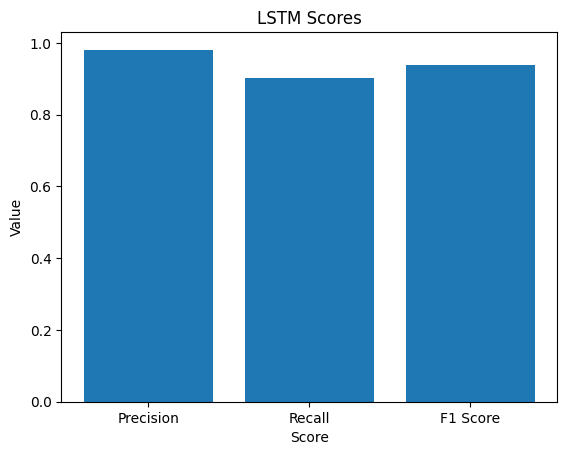

In [316]:
# Show the precision recall and f1 score on a chart
def plot_scores(scores, model_name):
    # Create a bar chart for the precision, recall, and F1 score
    plt.bar(x=['Precision', 'Recall', 'F1 Score'], height=scores)

    # Add a title and axis labels
    plt.title(f'{model_name} Scores')
    plt.xlabel('Score')
    plt.ylabel('Value')

    # Show the plot
    plt.show()

# Plot the scores for the LSTM model
plot_scores(scores=lstm_scores, model_name='LSTM')


In [317]:
bi_lstm_model = joblib.load('nlp_bi-lstm.pkl')

2023-04-26 22:41:08.871720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-26 22:41:08.874027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-26 22:41:08.875223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:
bi_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 200)              106400    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 266,601
Trainable params: 266,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Use Bi-LSTM model to predict sentiment for each song in the user playlist
def predict_sentiment(lyrics, model):
    # Encode the lyrics using the Tokenizer object
    padded_sequences = encoding(lyrics)[0]

    # Make predictions using the RNN model
    predictions = model.predict(padded_sequences)

    print(predictions)

    # Convert the predictions into sentiment labels
    sentiment_labels = ['positive' if prediction > 0.34 else 'negative' for prediction in predictions]

    return sentiment_labels

# Get the sentiment labels for each song in the user playlist
bi_lstm_sentiment_labels = predict_sentiment(user_playlist_lyrics, bi_lstm_model)

1/1 [==============================] - 0s 50ms/step
[[0.39592063]
 [0.3988632 ]
 [0.40372953]
 [0.40044624]
 [0.40321922]
 [0.38848376]
 [0.4000631 ]
 [0.34004912]
 [0.09696662]
 [0.4001946 ]]


In [322]:
df['bi_lstm_sentiment'] = ''

# Loop through each row in the df dataframe
for i in range(df.shape[0]):
    # Get the index of the row
    index = df.index[i]

    # Get the lyrics for the song
    lyrics = df.loc[index, 'clean_lyrics']

    # Predict the sentiment of the lyrics
    sentiment = predict_sentiment([lyrics], lstm_model)[0]

    # Update the sentiment column with the predicted sentiment
    df.loc[index, 'bi_lstm_sentiment'] = sentiment

print(df.head(5))

1/1 [==============================] - 0s 39ms/step
[[0.9868329]]
1/1 [==============================] - 0s 41ms/step
[[0.9868329]]
1/1 [==============================] - 0s 40ms/step
[[0.98683286]]
1/1 [==============================] - 0s 41ms/step
[[0.98683286]]
1/1 [==============================] - 0s 44ms/step
[[0.9868329]]
1/1 [==============================] - 0s 41ms/step
[[0.98683286]]
1/1 [==============================] - 0s 41ms/step
[[0.98683274]]
1/1 [==============================] - 0s 41ms/step
[[0.9868329]]
1/1 [==============================] - 0s 40ms/step
[[0.98683286]]
1/1 [==============================] - 0s 41ms/step
[[0.98689413]]
1/1 [==============================] - 0s 40ms/step
[[0.9868329]]
1/1 [==============================] - 0s 44ms/step
[[0.01494831]]
1/1 [==============================] - 0s 44ms/step
[[0.93089396]]
1/1 [==============================] - 0s 45ms/step
[[0.9868329]]
1/1 [==============================] - 0s 43ms/step
[[0.9868329]]
1/

In [326]:
# Grab the user's playlist lyrics from the user_playlists dictionary
user_playlist_lyrics = user_playlists[user]

# Grab the lyrics from the corresponding spotify IDs in the user_playlist_lyrics list
user_playlist_lyrics = df[df['spotify_id'].isin(user_playlist_lyrics)]['clean_lyrics'].values

# Encode the lyrics using the Tokenizer object
padded_sequences = encoding(user_playlist_lyrics)[0]

# Make predictions using the RNN model
bi_lstm_predictions = bi_lstm_model.predict(padded_sequences)

1/1 [==============================] - 0s 54ms/step


In [327]:
# Label each song in dataframe with correct sentiment label
for i in range(len(predictions)):
    if predictions[i] > 0.34:
        df['sentiment'].iloc[i] = 'positive'
    else:
        df['sentiment'].iloc[i] = 'negative'

# Convert the predictions into sentiment labels
bi_lstm_sentiment_labels = ['positive' if prediction > 0.34 else 'negative' for prediction in bi_lstm_predictions]

In [328]:
# Return songs that correspond with the ratio of positive and negative sentiment labels to the user
def bi_lstm_recommend_songs(sentiment_labels, user_playlist_lyrics, df, n=10):
    # Get the number of positive and negative sentiment labels
    num_positive = sentiment_labels.count('positive')
    num_negative = sentiment_labels.count('negative')

    # Calculate the ratio of positive and negative sentiment labels
    positive_ratio = num_positive / (num_positive + num_negative)
    negative_ratio = num_negative / (num_positive + num_negative)

    # Return songs that correspond with the ratio of positive and negative sentiment labels to the user
    if positive_ratio > negative_ratio:
        # Return the top-n songs with the highest positive sentiment
        return df[df['clean_lyrics'].isin(user_playlist_lyrics)][df['sentiment'] == 'positive']['spotify_id'].values[:n]
    else:
        # Return the top-n songs with the highest negative sentiment
        return df[df['clean_lyrics'].isin(user_playlist_lyrics)][df['sentiment'] == 'negative']['spotify_id'].values[:n]

In [330]:
# Get the recommended songs for the user
bi_lstm_recommended_songs = bi_lstm_recommend_songs(sentiment_labels=sentiment_labels, user_playlist_lyrics=user_playlist_lyrics, df=df)

# Convert this list to a dictionary
bi_lstm_recommended_songs = {user: rnn_recommended_songs}

print(bi_lstm_recommended_songs)

{'user100': {'user100': array(['06gD2ZtK3Dzc1BYqWExQJJ', '13e6f8t7RKXuxZ0JdaaJRG',
       '2272QqVQiM9VYGac3O2dVd', '5Wd2bfQ7wc6GgSa32OmQU3',
       '0elaYQVBPOQSp7G3P9AQ7C', '6TrLJzbFF1ynWWBipAlf0g',
       '7zywdG4ysfC5XNBzjQAo2o', '1DSJNBNhGZCigg9ll5VeZv'], dtype=object)}}


/var/folders/b8/tkxd7yxj1672bq9d4m_3xmhh0000gn/T/ipykernel_13747/3330376164.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df[df['clean_lyrics'].isin(user_playlist_lyrics)][df['sentiment'] == 'negative']['spotify_id'].values[:n]


In [331]:
# Generate precision, recall, and F1 scores for the LSTM model based on if the recommendations are in the user's playlist
def evaluate_model_bi_lstm(user_playlists, df, model, n=10):
    # Create a list to store the precision, recall, and F1 scores
    scores = []

    # Loop through each user in the user_playlists dictionary
    for user in user_playlists.keys():
        # Get the recommended songs for the user
        recommended_songs = recommend_songs_lstm(user=user, user_playlists=user_playlists, df=df, model=model, n=n)

        # Get the user's playlist
        user_playlist = user_playlists[user]

        # Calculate the precision, recall, and F1 score for the user
        precision = len(set(recommended_songs).intersection(set(user_playlist))) / len(recommended_songs)
        recall = len(set(recommended_songs).intersection(set(user_playlist))) / len(user_playlist)
        # Calculate the f1 score for the user's recommendations without zero division error
        if precision == 0 and recall == 0:
            f1_score = 0
        else:
            f1_score = 2 * (precision * recall) / (precision + recall)

        # Add the precision, recall, and F1 score to the scores list
        scores.append([precision, recall, f1_score])

    # Convert the scores list to a dataframe
    scores_df = pd.DataFrame(scores, columns=['Precision', 'Recall', 'F1 Score'])

    # Return the average precision, recall, and F1 score
    return scores_df.mean(axis=0)

# Evaluate the LSTM model
bi_lstm_scores = evaluate_model_bi_lstm(user_playlists=user_playlists, df=df, model=lstm_model)

print(bi_lstm_scores)

1/1 [==============================] - 0s 54ms/step


/var/folders/b8/tkxd7yxj1672bq9d4m_3xmhh0000gn/T/ipykernel_13747/2245358774.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df[df['clean_lyrics'].isin(user_playlist_lyrics)][df['sentiment'] == 'positive']['spotify_id'].values[:n]


1/1 [==============================] - 0s 42ms/step
Precision    0.981111
Recall       0.903000
F1 Score     0.938672
dtype: float64


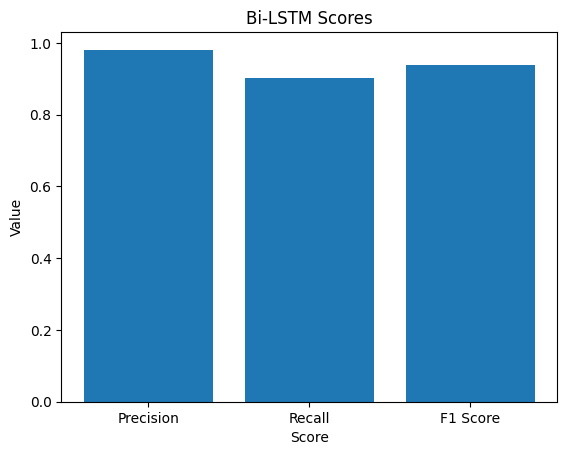

In [333]:
# Show the precision recall and f1 score on a chart
def plot_scores(scores, model_name):
    # Create a bar chart for the precision, recall, and F1 score
    plt.bar(x=['Precision', 'Recall', 'F1 Score'], height=scores)

    # Add a title and axis labels
    plt.title(f'{model_name} Scores')
    plt.xlabel('Score')
    plt.ylabel('Value')

    # Show the plot
    plt.show()

# Plot the scores for the LSTM model
plot_scores(scores=bi_lstm_scores, model_name='Bi-LSTM')

Writing the Cleaned Dataframe to the Database

In [ ]:
hostname="localhost"
dbname="music_app"
uname="root"
pwd=pwd

Create SQLAlchemy engine to connect to MySQL DB

In [ ]:
# Create the connection to the database
engine = create_engine(f'mysql+pymysql://{uname}:{pwd}@{hostname}/{dbname}')

In [ ]:
# Create the dataframe to be inserted into the database
sql_df = df

# Insert the dataframe into the database
sql_df.to_sql(
    name='billboard',
    con=engine,
    schema=None,
    if_exists='replace',
    index=False,
    index_label=None,
    chunksize=None,
    dtype=None,
    method=None,
)

6776